In [1]:
%load_ext line_profiler

In [2]:
import os

# 设置可见的 GPU，例如只使用 GPU 0 和 GPU 1
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

dim_feedforward = 1024
n_head = 2
n_layer = 2
scale_ratio = 2
horizon_len = 14
patch_len = 32
patch_num = 5
batch_size = 8
hidden_size = 128
#channels = ['Close', 'Volume'] #
channels = ['Close', 'High','Low',	'Open',	'Volume']
device = 'cuda'
train_ratio = 0.99
all_data_length = True

In [3]:
from deepdow.benchmarks import Benchmark, OneOverN, Random, MaximumReturn
from deepdow.callbacks import EarlyStoppingCallback, ModelCheckpointCallback, Callback
from deepdow.data import InRAMDataset, RigidDataLoader, prepare_standard_scaler, Scale
from deepdow.data.synthetic import sin_single
from deepdow.experiments import Run
from deepdow.layers import SoftmaxAllocator
from deepdow.losses import MeanReturns, SharpeRatio, MaximumDrawdown
from deepdow.visualize import generate_metrics_table, generate_weights_table, plot_metrics, plot_weight_heatmap
from deepdow.layers import NumericalMarkowitz
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from os import path
from typing import Optional, Tuple

import numpy as np
import pandas as pd
import torch
import torch.multiprocessing as mp
import yfinance as yf
from finetuning.finetuning_torch import FinetuningConfig, TimesFMFinetuner
from huggingface_hub import snapshot_download
from torch.utils.data import Dataset

from timesfm import TimesFm, TimesFmCheckpoint, TimesFmHparams
from timesfm.pytorch_patched_decoder import PatchedTimeSeriesDecoder
import os
from deepdow.layers import Conv
from deepdow.layers.collapse import AttentionCollapse, AverageCollapse
from deepdow.layers.misc import CovarianceMatrix
import h5py

 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.


/home/userroot/miniconda3/envs/ts/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded PyTorch TimesFM, likely because python version is 3.11.11 (main, Dec 11 2024, 16:28:39) [GCC 11.2.0].


In [4]:
from deepdow.callbacks import (
    BenchmarkCallback,
    EarlyStoppingException,
    ProgressBarCallback,
    ValidationCallback,
)
from diffcp import SolverError
import datetime
import time
class DeepRun(Run):
    def __init__(self, network, loss, train_dataloader, val_dataloaders=None, metrics=None, benchmarks=None, device=None, dtype=None, optimizer=None, callbacks=None):
        super().__init__(network, loss, train_dataloader, val_dataloaders, metrics, benchmarks, device, dtype, optimizer, callbacks)
    
    def launch(self, n_epochs=1):
        """Launch the training and logging loop.

        Parameters
        ----------
        n_epochs : int
            Number of epochs.
        """
        try:
            self.network.to(device=self.device, dtype=self.dtype)
            # Train begin
            if self.current_epoch == -1:
                self.on_train_begin(metadata={"n_epochs": n_epochs})

            for _ in range(n_epochs):
                self.current_epoch += 1
                # Epoch begin
                self.on_epoch_begin(metadata={"epoch": self.current_epoch})

                for batch_ix, (
                    X_batch,
                    y_batch,
                    timestamps,
                    asset_names,
                ) in enumerate(self.train_dataloader):
                    # Batch begin
                    self.on_batch_begin(
                        metadata={
                            "asset_names": asset_names,
                            "batch": batch_ix,
                            "epoch": self.current_epoch,
                            "timestamps": timestamps,
                            "X_batch": X_batch,
                            "y_batch": y_batch,
                        }
                    )

                    # Get batch
                    X_batch, y_batch = X_batch.to(self.device).to(
                        self.dtype
                    ), y_batch.to(self.device).to(self.dtype)

                    # Make sure network on the right device and train mode
                    self.network.train()

                    # Forward & Backward
                    weights = self.network(X_batch, y_batch, timestamps, asset_names)
                    loss_per_sample = self.loss(weights, y_batch)
                    loss = loss_per_sample.mean()
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()

                    # Switch back to eval mode
                    self.network.eval()

                    # Batch end
                    self.on_batch_end(
                        metadata={
                            "asset_names": asset_names,
                            "batch": batch_ix,
                            "batch_loss": loss.item(),
                            "epoch": self.current_epoch,
                            "timestamps": timestamps,
                            "weights": weights,
                            "X_batch": X_batch,
                            "y_batch": y_batch,
                        }
                    )

                # Epoch end
                self.on_epoch_end(
                    metadata={
                        "epoch": self.current_epoch,
                        "n_epochs": n_epochs,
                    }
                )

            # Train end
            self.on_train_end()

        except (EarlyStoppingException, KeyboardInterrupt, SolverError) as ex:
            print("Training interrupted")
            time.sleep(1)

            self.on_train_interrupt(
                metadata={"exception": ex, "locals": locals()}
            )

        return self.history



In [5]:
import pandas as pd
if all_data_length:
    df = pd.read_parquet('df.parquet')
else:
    df = pd.read_parquet('df.parquet')[-500:]

In [6]:
# def get_model(load_weights: bool = False, horizon_len: int = 7):
#   device = "gpu" if torch.cuda.is_available() else "cpu"
#   repo_id = "google/timesfm-2.0-500m-pytorch"
#   hparams = TimesFmHparams(
#       backend=device,
#       per_core_batch_size=32,
#       horizon_len=horizon_len,
#       num_layers=50,
#       use_positional_embedding=False,
#       context_len=2048,  # Context length can be anything up to 2048 in multiples of 32
#       input_patch_len=patch_len
#   )
#   tfm = TimesFm(hparams=hparams,
#                 checkpoint=TimesFmCheckpoint(huggingface_repo_id=repo_id))

#   model = PatchedTimeSeriesDecoder(tfm._model_config)
#   if load_weights:
#     checkpoint_path = path.join(snapshot_download(repo_id), "torch_model.ckpt")
#     loaded_checkpoint = torch.load(checkpoint_path, weights_only=True)
#     model.load_state_dict(loaded_checkpoint)
#   return model, hparams, tfm._model_config

In [7]:
import timesfm
# For Torch
tfm = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
          backend="gpu",
          per_core_batch_size=batch_size,
          horizon_len=horizon_len,
          num_layers=50,
          use_positional_embedding=False,
          context_len=768,
      ),
      checkpoint=timesfm.TimesFmCheckpoint(
          huggingface_repo_id="google/timesfm-2.0-500m-pytorch"),
  )

Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 26817.80it/s]


In [8]:
from deepdow.utils import raw_to_Xy


n_timesteps = len(df)  # 20
n_channels = len(channels)  # 2
n_assets = len(df.columns.levels[0])  # 2

lookback, gap, horizon = patch_len*patch_num, 2, horizon_len

X, timestamps, y, asset_names, indicators = raw_to_Xy(df,
                                                      lookback=lookback,
                                                      gap=gap,
                                                      freq="B",
                                                      horizon=horizon,
                                                      included_indicators=channels)

n_samples =  n_timesteps - lookback - horizon - gap + 1  # 10

# assert X.shape == (n_samples, n_channels, lookback, n_assets)
# assert timestamps[0] == raw_df.index[lookback]
# assert asset_names == tickers
# assert indicators == ['Close', 'High', 'Low', 'Open', 'Volume']

In [9]:
print(lookback)
print(df.index[lookback])
print(timestamps[0])
print(df.index[0])

160
2006-11-10 00:00:00
2006-11-06 00:00:00
2006-03-27 00:00:00


In [10]:
print('X: {}, y: {}'.format(X.shape, y.shape))

X: (4782, 5, 160, 30), y: (4782, 5, 14, 30)


In [11]:
n_samples

4606

In [12]:
split_ix = int(n_samples * train_ratio)
indices_train = list(range(split_ix))
#indices_test = list(range(split_ix + lookback + horizon, n_samples))
indices_test = list(range(split_ix + horizon, n_samples))

print('Train range: {}:{}\nTest range: {}:{}'.format(indices_train[0], indices_train[-1],
                                                     indices_test[0], indices_test[-1]))

Train range: 0:4558
Test range: 4573:4605


In [13]:
timestamps[4389]

Timestamp('2023-09-01 00:00:00')

In [14]:
specific_date = '2024-12-01 00:00:00'

# 方法 1：使用 xs 选择 Close 列
close_data = df.xs('Close', level='Price', axis=1)[df.index > specific_date]

<Axes: xlabel='Date'>

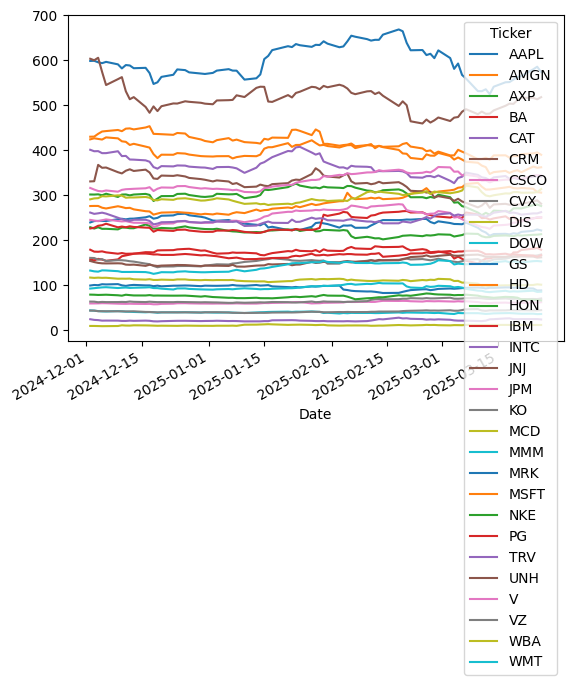

In [15]:
close_data.plot()

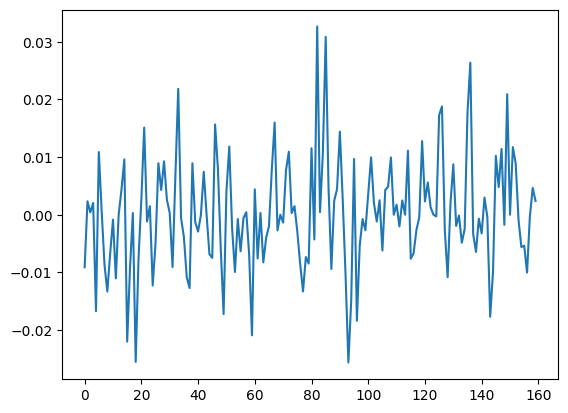

In [16]:
plt.plot(X[1, 1, :, 1])

In [17]:
means, stds = prepare_standard_scaler(X, indices=indices_train)
print('mean: {}, std: {}'.format(means, stds))

mean: [ 3.85875983e-04  3.84206359e-04  3.84638461e-04  3.84143322e-04
 -5.85685337e-05], std: [0.01754958 0.01499561 0.01661025 0.0173953  0.34227451]


In [18]:
dataset = InRAMDataset(X, y, timestamps = timestamps, asset_names = asset_names, transform=Scale(means, stds))

In [19]:
dataloader_train = RigidDataLoader(dataset,
                                   indices=indices_train,
                                   batch_size=batch_size, persistent_workers=True, pin_memory=True, num_workers=16, prefetch_factor=2)

dataloader_test = RigidDataLoader(dataset,
                                  indices=indices_test,
                                  batch_size=batch_size)

In [20]:
# sfm_model, a, b = get_model(load_weights=True)
# sfm_model.to('cuda')

sfm_model = tfm._model

In [21]:
import math
from re import M
class DeepNet(torch.nn.Module, Benchmark):
    def get_sinusoidal_positional_encoding(self, max_len, d_model):
        """
        生成正弦位置编码
        :param max_len: 最大序列长度
        :param d_model: 嵌入维度
        :return: 位置编码矩阵，形状为 (max_len, d_model)
        """
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe

    def generate_square_subsequent_mask(self, sz):
        """生成因果掩码，sz 是目标序列长度"""
        mask = torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)
        return mask
    
    def generate_assets_embedding(self, x, n_assets): # x: B,  channels, lookback, n_assets
        """生成资产嵌入向量"""
        x = x.permute(0,2,3,1) # B, lookback, n_assets, channels
        
        tensor = torch.arange(0, n_assets, dtype=torch.long).to(device)
        assets_emb = self.embedding(tensor)
        assets_emb = assets_emb.unsqueeze(0).unsqueeze(0).repeat(x.shape[0], x.shape[1], 1, 1)
        x = self.embedding_layer_4(x) + assets_emb # B, lookback, n_assets, emb_dim + 
        
        
        return x
    
    def __init__(self, n_assets, lookback, channels, hidden_size = 128, p=0.4, max_weight=1., n_output_channels = 4, dim_feedforward=96, scale_ratio = 2, n_layer = 4, n_head = 2):
        super().__init__()
        import random

        self.result = random.choice([True, False])
        # 定义嵌入层
        vocab_size = n_assets  # 词汇表大小（假设有10个不同的索引）
        self.embedding_dim = channels*scale_ratio  # 每个索引映射到4维向量
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim)
        
                
        n_features =  patch_num * 128 # 输入特征数
        predict_patch_num = (horizon_len + 128 -1) // 128
        scale_ratio = scale_ratio
        self.CollapseChannel = Conv(n_input_channels=channels,
             n_output_channels=1,
             kernel_size=3,
             method='2D')
        
        self.embedding_layer_4 = nn.Linear(channels, self.embedding_dim, bias=True)
        self.embedding_layer_3 = nn.Linear(n_assets*channels, n_assets*scale_ratio, bias=True)
        self.embedding_layer_2 = nn.Linear(n_assets*self.embedding_dim, n_assets*scale_ratio, bias=True)
        self.embedding_layer_1 = nn.Linear(n_assets*self.embedding_dim, n_assets*scale_ratio, bias=True)
        self.cross_embedding_layer = nn.Linear(896, n_assets*scale_ratio, bias=True)
        # 参数
        d_model = n_assets*scale_ratio  # 隐藏维度
        nhead = n_head      # 注意力头数
        num_encoder_layers = n_layer  # 编码器层数
        num_decoder_layers = n_layer  # 解码器层数
        dim_feedforward = dim_feedforward  # 前馈层中间维度
        dropout = 0.2
        self.encoder_layer = nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                dropout=dropout,
                batch_first=True
            )
        self.encoder_layer_2 = nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                dropout=dropout,
                batch_first=True
            )
        self.decoder_layer = nn.TransformerDecoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                dropout=dropout,
                batch_first=True
            )
        self.cross_decoder_layer = nn.TransformerDecoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                dropout=dropout,
                batch_first=True
            )
        self.decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=num_decoder_layers)
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_encoder_layers)
        self.encoder_2 = nn.TransformerEncoder(self.encoder_layer_2, num_layers=num_encoder_layers)
        self.cross_decoder = nn.TransformerDecoder(self.cross_decoder_layer, num_layers=num_decoder_layers)
        self.mask = self.generate_square_subsequent_mask(lookback).to('cuda')
        self.mask_2 = self.generate_square_subsequent_mask(horizon_len).to('cuda')
        layers = []

        layers.append(nn.Linear(n_features, 1))
        layers.append(nn.ReLU())
        self.CollapseSFM = nn.Sequential(*layers)
        
        self.layer_L3 = AverageCollapse()
        self.layer_L4 = CovarianceMatrix(sqrt=False)
        self.layer_L5 = NumericalMarkowitz(n_assets)
        # Dropout 层
        self.dropout_layer = nn.Dropout(p=p)
        
        # 10 层网络
        layers = []
        # 第 1 层：输入层
        layers.append(nn.Linear(patch_num*1280, hidden_size))
        layers.append(nn.ReLU())
        
        
        # 将所有层组合成 Sequential
        self.network = nn.Sequential(*layers)
        self.dense_layer = torch.nn.Linear(n_assets*scale_ratio, n_assets, bias=True)
        self.dense_layer_2 = torch.nn.Linear(channels, 1, bias=True)
        
        # Softmax 分配层和温度参数
        self.allocate_layer = SoftmaxAllocator(temperature=None, n_assets= n_assets, formulation='variational', max_weight=1)
        self.temperature = nn.Parameter(torch.ones(1), requires_grad=True)
        

    def forward(self, x, y_batch=None, timestamps=None, asset_names=None):

        """Perform forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Of shape (n_samples, 1, lookback, n_assets).

        Returns
        -------
        weights : torch.Torch
            Tensor of shape (n_samples, n_assets).

        """
        # if timestamps is not None:
        #     script_features = []
        #     for timestamp in timestamps:
        #         script_f = get_values_before_date(mean_content, timestamp)[-200:]
        #         script_f = torch.stack(script_f, dim=0) # 200, 896
        #         script_features.append(script_f)
        #     script_tensor = torch.stack(script_features, dim=0)
        
        # script_tensor = script_tensor.to(device)
        # script_tensor = self.cross_embedding_layer(script_tensor)
        
        
        n_samples, channels, lookback, n_assets = x.shape
        
        self.x_positional_encoding = self.get_sinusoidal_positional_encoding(lookback, self.embedding_dim).unsqueeze(0).unsqueeze(1).repeat(n_samples, 1, n_assets, 1).reshape(n_samples, lookback, -1)
        self.x_positional_encoding = self.x_positional_encoding.to(device)
        
        x_emb = self.generate_assets_embedding(x, n_assets) #B, lookback, n_assets, embedding_dim
        x_emb = x_emb.reshape(n_samples, lookback, -1) + self.x_positional_encoding
        
        
        if y_batch is not None:
            y = self.generate_assets_embedding(y_batch, n_assets) #B, horizon_len, n_assets, embedding_dim
            # y = y_batch.permute(0, 2, 1,3) #B, channels, horizon_len, n_assets
            y = y.reshape(n_samples, horizon_len, -1)
            y_positional_encoding = self.get_sinusoidal_positional_encoding(horizon_len, self.embedding_dim).unsqueeze(0).unsqueeze(1).repeat(n_samples, 1, n_assets, 1).reshape(n_samples, horizon_len, -1).to(device)
            y = y + y_positional_encoding
            y = self.embedding_layer_2(y) 
        
        x = x.permute(0, 3, 1, 2) #B, n_assets, channels, lookback
        x = x.reshape(n_samples, n_assets*channels, lookback) #b, n_assets*channels, lookback

        
        if True: 
            m = x.reshape(-1, lookback)
            input_padding = torch.zeros_like(m).to(device)
            freq = torch.tensor([0], dtype=torch.long).to(device)
            with torch.no_grad():
                m = sfm_model(m, input_padding, freq)
            #m = sfm_model(m, input_padding, freq)
            m = m[:,:,:,0]
            m = m[:, -1, :horizon_len]
            m = m.reshape(-1, n_assets, channels, m.shape[1] )
            
            m = m.permute(0,2,3,1) #B, channels, horizon_len, n_assets
            m = self.generate_assets_embedding(m, n_assets) # B, horizon_len, n_assets, emb_dim
            m = m.reshape(n_samples, horizon_len, -1)
            m_positional_encoding = self.get_sinusoidal_positional_encoding(horizon_len, self.embedding_dim).unsqueeze(0).unsqueeze(1).repeat(n_samples, 1, n_assets, 1).reshape(n_samples, horizon_len, -1).to(device)
            m = m + m_positional_encoding
            m = self.embedding_layer_1(m)   #B, horizon_len, n_assets*sclale_ratio
            
            #m = self.dropout_layer(m)
            #m = self.encoder(m) #B, horizon_len, n_assets*sclale_ratio
        #m = m[:,-1,:]
        # m = m[:,:,0:horizon_len]  # B, channels*n_assets, horizon_len
        # m = m.permute(0,2,1) # B, horizon_len, channels*n_assets
        # m = self.embedding_layer_1(m) # B, horizon_len, n_assets*sclale_ratio
        # # m 不需要std化 
        # x = x.permute(0, 2, 1) # B, lookback, n_assets*channels
        x = self.embedding_layer_2(x_emb) # B, lookback, n_assets*sclale_ratio
        x = self.encoder_2(x)
        #x = self.dropout_layer(x)
        if y_batch is not None and self.result:
            m = self.cross_decoder(m, y[:,-1:,:], self.generate_square_subsequent_mask(m.shape[1]))
            x = self.decoder(m, x, self.generate_square_subsequent_mask(y.shape[1])) 
        else:
            #x = self.decoder(x[:,-1:,:], x, self.generate_square_subsequent_mask(1))
            x = self.cross_decoder(m, x[:,-1:,:], self.generate_square_subsequent_mask(m.shape[1]))
            #x = self.decoder(m, x, self.generate_square_subsequent_mask(m.shape[1]))
        #x = self.cross_decoder(x, m, self.mask_2)
        x = x[:,-1, :] #B, 1, n_assets*sclale_ratio
        #x = x + m
        x = x.reshape(n_samples, -1) #B, 1, n_assets*sclale_ratio
        x = self.dense_layer(x) # B, lookback, n_assets*sclale_ratio
        # # #x = self.cross_decoder(x, script_tensor)
        # # x = self.decoder(m, x) # B, patch_num, n_assets*sclale_ratio
        # # #x = self.decoder(x, m) # B, lookback, n_assets*scale_ratio
        # # #x = x.permute(0, 2, 1)
        # x = self.decoder(m, m, self.mask) # B, horizon_len, n_assets*sclale_ratio
        #x = x.reshape(n_samples,  -1) #B, n_assets, horizon_len*scale_ratio
        #x = x[:,-1, :]
        
        
        #x = self.dropout_layer(x)
        #m = self.dense_layer_2(m)
        
        #x = self.dense_layer(x)
        x = x.squeeze(-1)
        # 计算权重
        temperatures = torch.ones(n_samples).to(device=x.device, dtype=x.dtype) * self.temperature
        weights = self.allocate_layer(x, temperatures)

        return weights

In [22]:
from deepdow.nn import BachelierNet

n_input_channels = len(channels)
max_weight = 1
hidden_size = 32
network = None


In [23]:
if True:
    #network = GreatNet(n_assets, lookback, channels=n_channels, hidden_size=hidden_size,p=0.4)
    network = DeepNet(n_assets, lookback, channels=n_channels, hidden_size=hidden_size,p=0.4, dim_feedforward=dim_feedforward, scale_ratio=scale_ratio, n_layer=n_layer, n_head=n_head)
else:
    network = BachelierNet(n_input_channels, n_assets, hidden_size=hidden_size, max_weight=max_weight)


In [24]:
network_to_train = network.train() 

In [25]:
loss = MaximumDrawdown() + 2 * MeanReturns() + SharpeRatio(rf=0.000)
#loss = MeanReturns()

In [26]:
#获得时间 作为文件名
from datetime import datetime
now = datetime.now()
date_time = now.strftime("%Y-%m-%d %H-%M-%S")
run = DeepRun(network_to_train,
          loss,
          dataloader_train,
          benchmarks={'OneOverN': OneOverN(),
                      'MaximumReturn': MaximumReturn(),
                     },
          val_dataloaders={'test': dataloader_test},
          optimizer=torch.optim.Adam(network.parameters(), amsgrad=True, lr=0.001),
          callbacks=[EarlyStoppingCallback(metric_name='loss',
                                           dataloader_name='test',
                                           patience=15),
                     ModelCheckpointCallback(folder_path=f'./models/{date_time}_ffn_{dim_feedforward}_scale_{scale_ratio}_nlayer_{n_layer}_nhead_{n_head}/',
                                             dataloader_name='test',
                                             metric_name='loss')],
          device=device
          )

#

In [27]:

# %lprun -f run.launch run.launch(2)

In [ ]:
history = run.launch(5)

model          metric  epoch  dataloader
MaximumReturn  loss    -1     test         -0.081
OneOverN       loss    -1     test         -0.051


Epoch 0:  45%|████▍     | 256/570 [02:57<03:41,  1.42it/s, loss=-0.10422]

In [ ]:
per_epoch_results = history.metrics.groupby(['dataloader', 'metric', 'model', 'epoch'])['value']

print(per_epoch_results.count())  # double check number of samples each epoch
print(per_epoch_results.mean())  # mean loss per epoch

dataloader  metric  model          epoch
test        loss    MaximumReturn  -1       33
                    OneOverN       -1       33
                    network         0       33
                                    1       33
                                    2       33
                                    3       33
                                    4       33
Name: value, dtype: int64
dataloader  metric  model          epoch
test        loss    MaximumReturn  -1      -0.081
                    OneOverN       -1      -0.051
                    network         0      -0.266
                                    1      -0.273
                                    2      -0.252
                                    3      -0.234
                                    4      -0.273
Name: value, dtype: float32


<Axes: xlabel='epoch'>

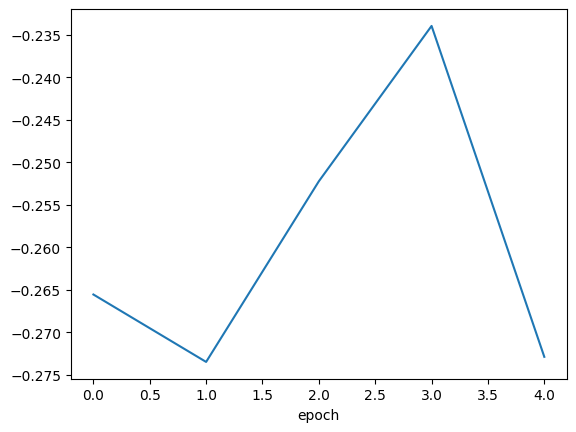

In [ ]:
per_epoch_results.mean()['test']['loss']['network'].plot()

In [ ]:
from json import load

model_path = f'./models/{date_time}_ffn_{dim_feedforward}_scale_{scale_ratio}_nlayer_{n_layer}_nhead_{n_head}/'
#获得model_path下日期最新的文件
best_model_file = model_path + sorted(os.listdir(model_path), key=lambda x: os.path.getmtime(os.path.join(model_path, x)), reverse=True)[0]
print(f'best model file: {best_model_file}')

loaded_network = torch.load(best_model_file, weights_only=False)
loaded_network.eval()

best model file: ./models/2025-04-25 10-35-45_ffn_1024_scale_2_nlayer_2_nhead_2/model_01__-0.2735.pth


DeepNet(
  (embedding): Embedding(30, 4)
  (CollapseChannel): Conv(
    (conv): Conv2d(2, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (embedding_layer_4): Linear(in_features=2, out_features=4, bias=True)
  (embedding_layer_3): Linear(in_features=60, out_features=60, bias=True)
  (embedding_layer_2): Linear(in_features=120, out_features=60, bias=True)
  (embedding_layer_1): Linear(in_features=120, out_features=60, bias=True)
  (cross_embedding_layer): Linear(in_features=896, out_features=60, bias=True)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=60, out_features=60, bias=True)
    )
    (linear1): Linear(in_features=60, out_features=1024, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (linear2): Linear(in_features=1024, out_features=60, bias=True)
    (norm1): LayerNorm((60,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((60,), eps=1e-05, elementw

In [ ]:
network = network.eval()

In [ ]:
benchmarks = {
    '1overN': OneOverN(),  # each asset has weight 1 / n_assets
    #'MaximumReturn': MaximumReturn(),  # random allocation that is however close 1OverN
    #'network': network,
    'best_network': loaded_network
}

In [ ]:
metrics = {
    'MaxDD': MaximumDrawdown(),
    'Sharpe': SharpeRatio(),
    'MeanReturn': MeanReturns()
}

In [ ]:
metrics_table = generate_metrics_table(benchmarks,
                                       dataloader_test,
                                       metrics,
                                       device='cuda')

array([<Axes: title={'center': 'MaxDD'}, xlabel='timestamp'>,
       <Axes: title={'center': 'Sharpe'}, xlabel='timestamp'>,
       <Axes: title={'center': 'MeanReturn'}, xlabel='timestamp'>],
      dtype=object)

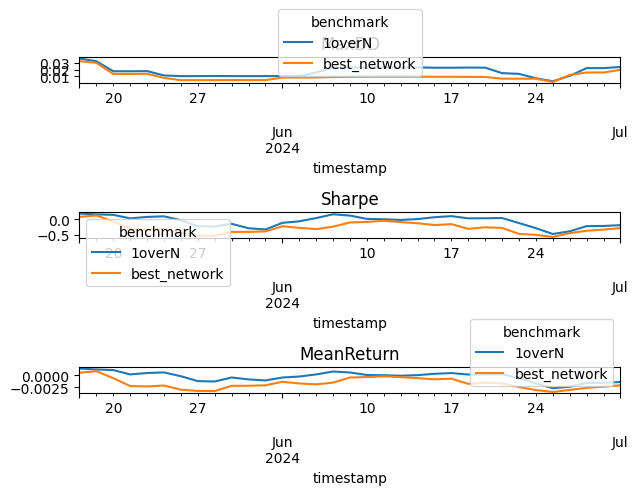

In [ ]:
plot_metrics(metrics_table)

In [ ]:
weight_table = generate_weights_table(network, dataloader_test,device = device)

<Axes: >

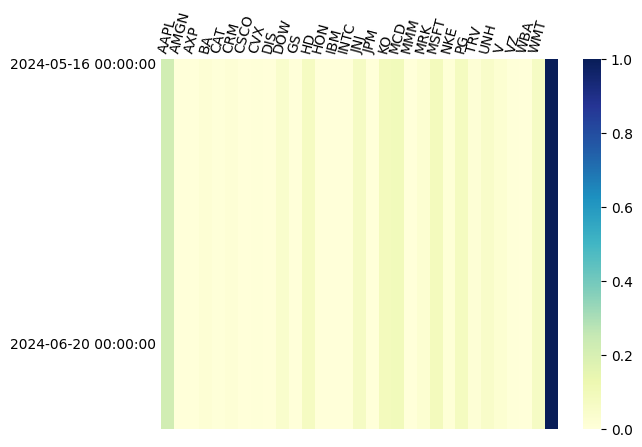

In [ ]:
plot_weight_heatmap(weight_table,
                    add_sum_column=True,
                    time_format=None,
                    time_skips=25)

<Axes: >

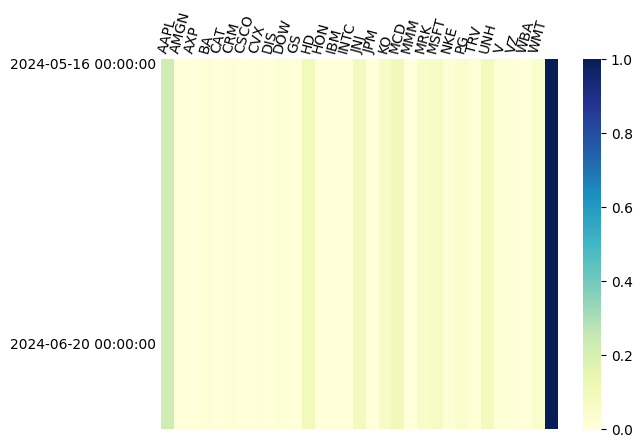

In [ ]:
weight_table = generate_weights_table(loaded_network, dataloader_test,device = device)
plot_weight_heatmap(weight_table,
                    add_sum_column=True,
                    time_format=None,
                    time_skips=25)

In [ ]:
pd.set_option('display.precision', 10)
print(weight_table['AAPL'])

2024-05-16   0.226
2024-05-17   0.226
2024-05-20   0.226
2024-05-21   0.226
2024-05-22   0.226
2024-05-23   0.226
2024-05-24   0.226
2024-05-27   0.226
2024-05-28   0.226
2024-05-29   0.226
2024-05-30   0.226
2024-05-31   0.226
2024-06-03   0.226
2024-06-04   0.226
2024-06-05   0.226
2024-06-06   0.226
2024-06-07   0.226
2024-06-10   0.226
2024-06-11   0.226
2024-06-12   0.226
2024-06-13   0.226
2024-06-14   0.226
2024-06-17   0.226
2024-06-18   0.226
2024-06-19   0.226
2024-06-20   0.226
2024-06-21   0.226
2024-06-24   0.226
2024-06-25   0.226
2024-06-26   0.226
2024-06-27   0.226
2024-06-28   0.226
2024-07-01   0.226
Name: AAPL, dtype: float32
